# Vision Transformer for Traction Force Microscopy (ViT-TFM)

In [1]:
import VisionTransformer as vit

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

2022-11-11 22:17:14.896729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [3]:
collect()
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


## 1. Taxonomy of an inverse problem
Ongie, G., Jalal, A., Metzler, C. A., Baraniuk, R. G., Dimakis, A. G. & Willett, R. (2020). Deep Learning Techniques for Inverse Problems in Imaging. IEEE Journal on Selected Areas in Information Theory, 1(1), 39–56. https://doi.org/10.1109/jsait.2020.2991563

<h4><center>$y = A(x) + \epsilon$</center></h4>

- $y$: measurement (e.g. displacements)
- $x$: signal (e.g. traction forces)
- $A$: (non-linear) foward operator
- $\epsilon$: noise

__Goal__: recover $x$ from $y$

__Problem__: A is ill-posed, (matrix-) inversion is not possible


__Approach__: 
  1. Supervised approach: create a matched dataset by simulating the forward operator on clean data.
  2. Train model to reconstruct signal by taking (corrupted) measurements as input.
  3. Generalize to unseen measurements.

## 2. Comparison: CNN from [Kratz et al.](https://www.biorxiv.org/content/biorxiv/early/2022/09/03/2022.09.02.506331.full.pdf) and ViT

This section serves as a 'sanity check' for my ViT architecture modified for TFM. I trained the model on a set of 25.000 clean pairs of (displacement fields, traction fields) for 10 epochs without any hyperparameter tuning.

Load weights of benchmark CNN and my ViT.

In [4]:
vit_weights = vit.VisionTransformer(dspl_size=104, patch_size=8, embed_dim=128, depth=12, n_heads=8, mlp_ratio=4.,p=0., attn_p=0.,drop_path=0).double()

In [5]:
if torch.cuda.is_available():
    vit_weights.load_state_dict(torch.load('logs_and_weights/ViT-2022-Nov-03 09:55:11/ViT-2022-Nov-03 09:55:11_best_val_loss_2e-05.pth')['best_model_weights'], strict=False)
else:
    vit_weights.load_state_dict(torch.load('logs_and_weights/ViT-2022-Nov-03 09:55:11/ViT-2022-Nov-03 09:55:11_best_val_loss_2e-05.pth', map_location=torch.device('cpu'))['best_model_weights'], strict=False)        

In [6]:
cnn_weights = keras.models.load_model('../mltfm/models/model_noise_1e-4.h5')

2022-11-11 22:17:22.307147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load a test set of 25 clean samples. Neither the CNN nor the ViT have seen these during training.

In [7]:
dspl = h5py.File('data/displacements_25.h5')["data"]
trac = h5py.File('data/tractions_25.h5')["data"]

dspl_ = np.moveaxis(np.array(dspl),3 ,1)
trac_ = np.moveaxis(np.array(trac),3 ,1)

X_test = torch.from_numpy(dspl_).double()
Y_test = torch.from_numpy(trac_).double()

Compute the predictions and losses for each sample.

In [8]:
pred_vit, _ = vit_weights(X_test)
pred_cnn = cnn_weights.predict(dspl)

1/1 [==============================] - 0s 478ms/step


In [9]:
loss = torch.nn.MSELoss(reduction='none')
loss_vit = torch.sum(loss(pred_vit, Y_test), (1, 2, 3))
loss_cnn = torch.sum(loss(torch.tensor(np.moveaxis(pred_cnn, 3, 1)), Y_test), (1, 2, 3))

loss_vit = torch.reshape(loss_vit, (25, 1))
loss_cnn = torch.reshape(loss_cnn, (25, 1))

In [10]:
pd.DataFrame(np.array(torch.cat((loss_vit, loss_cnn), 1).detach().numpy()), columns=['loss_ViT', 'loss_CNN'])

loss_ViT  loss_CNN
0   2.753814  0.953331
1   4.901701  2.071338
2   2.239506  0.819685
3   2.465992  1.019594
4   3.118751  1.171546
5   4.250527  1.809746
6   2.809118  1.016019
7   5.284278  2.160380
8   3.905215  1.641007
9   6.274332  2.361687
10  2.118393  0.882499
11  5.836583  2.435076
12  2.805128  1.104939
13  3.904149  1.096354
14  4.696601  2.039140
15  3.914951  1.749880
16  3.102587  1.241892
17  2.278443  1.051530
18  3.439640  1.436726
19  2.816243  1.241582
20  6.012573  1.953752
21  3.425923  1.098682
22  2.079837  0.826819
23  2.525014  0.999485
24  3.427333  1.288315

The per sample loss of the ViT is approximately 3x larger than the CNN loss. This could be rooted in the significantly recuced training time of the vanilla ViT (10 epochs) compared to the training time of the tuned CNN (100 epochs).

Visualize the first test sample.

<IPython.core.display.Javascript object>


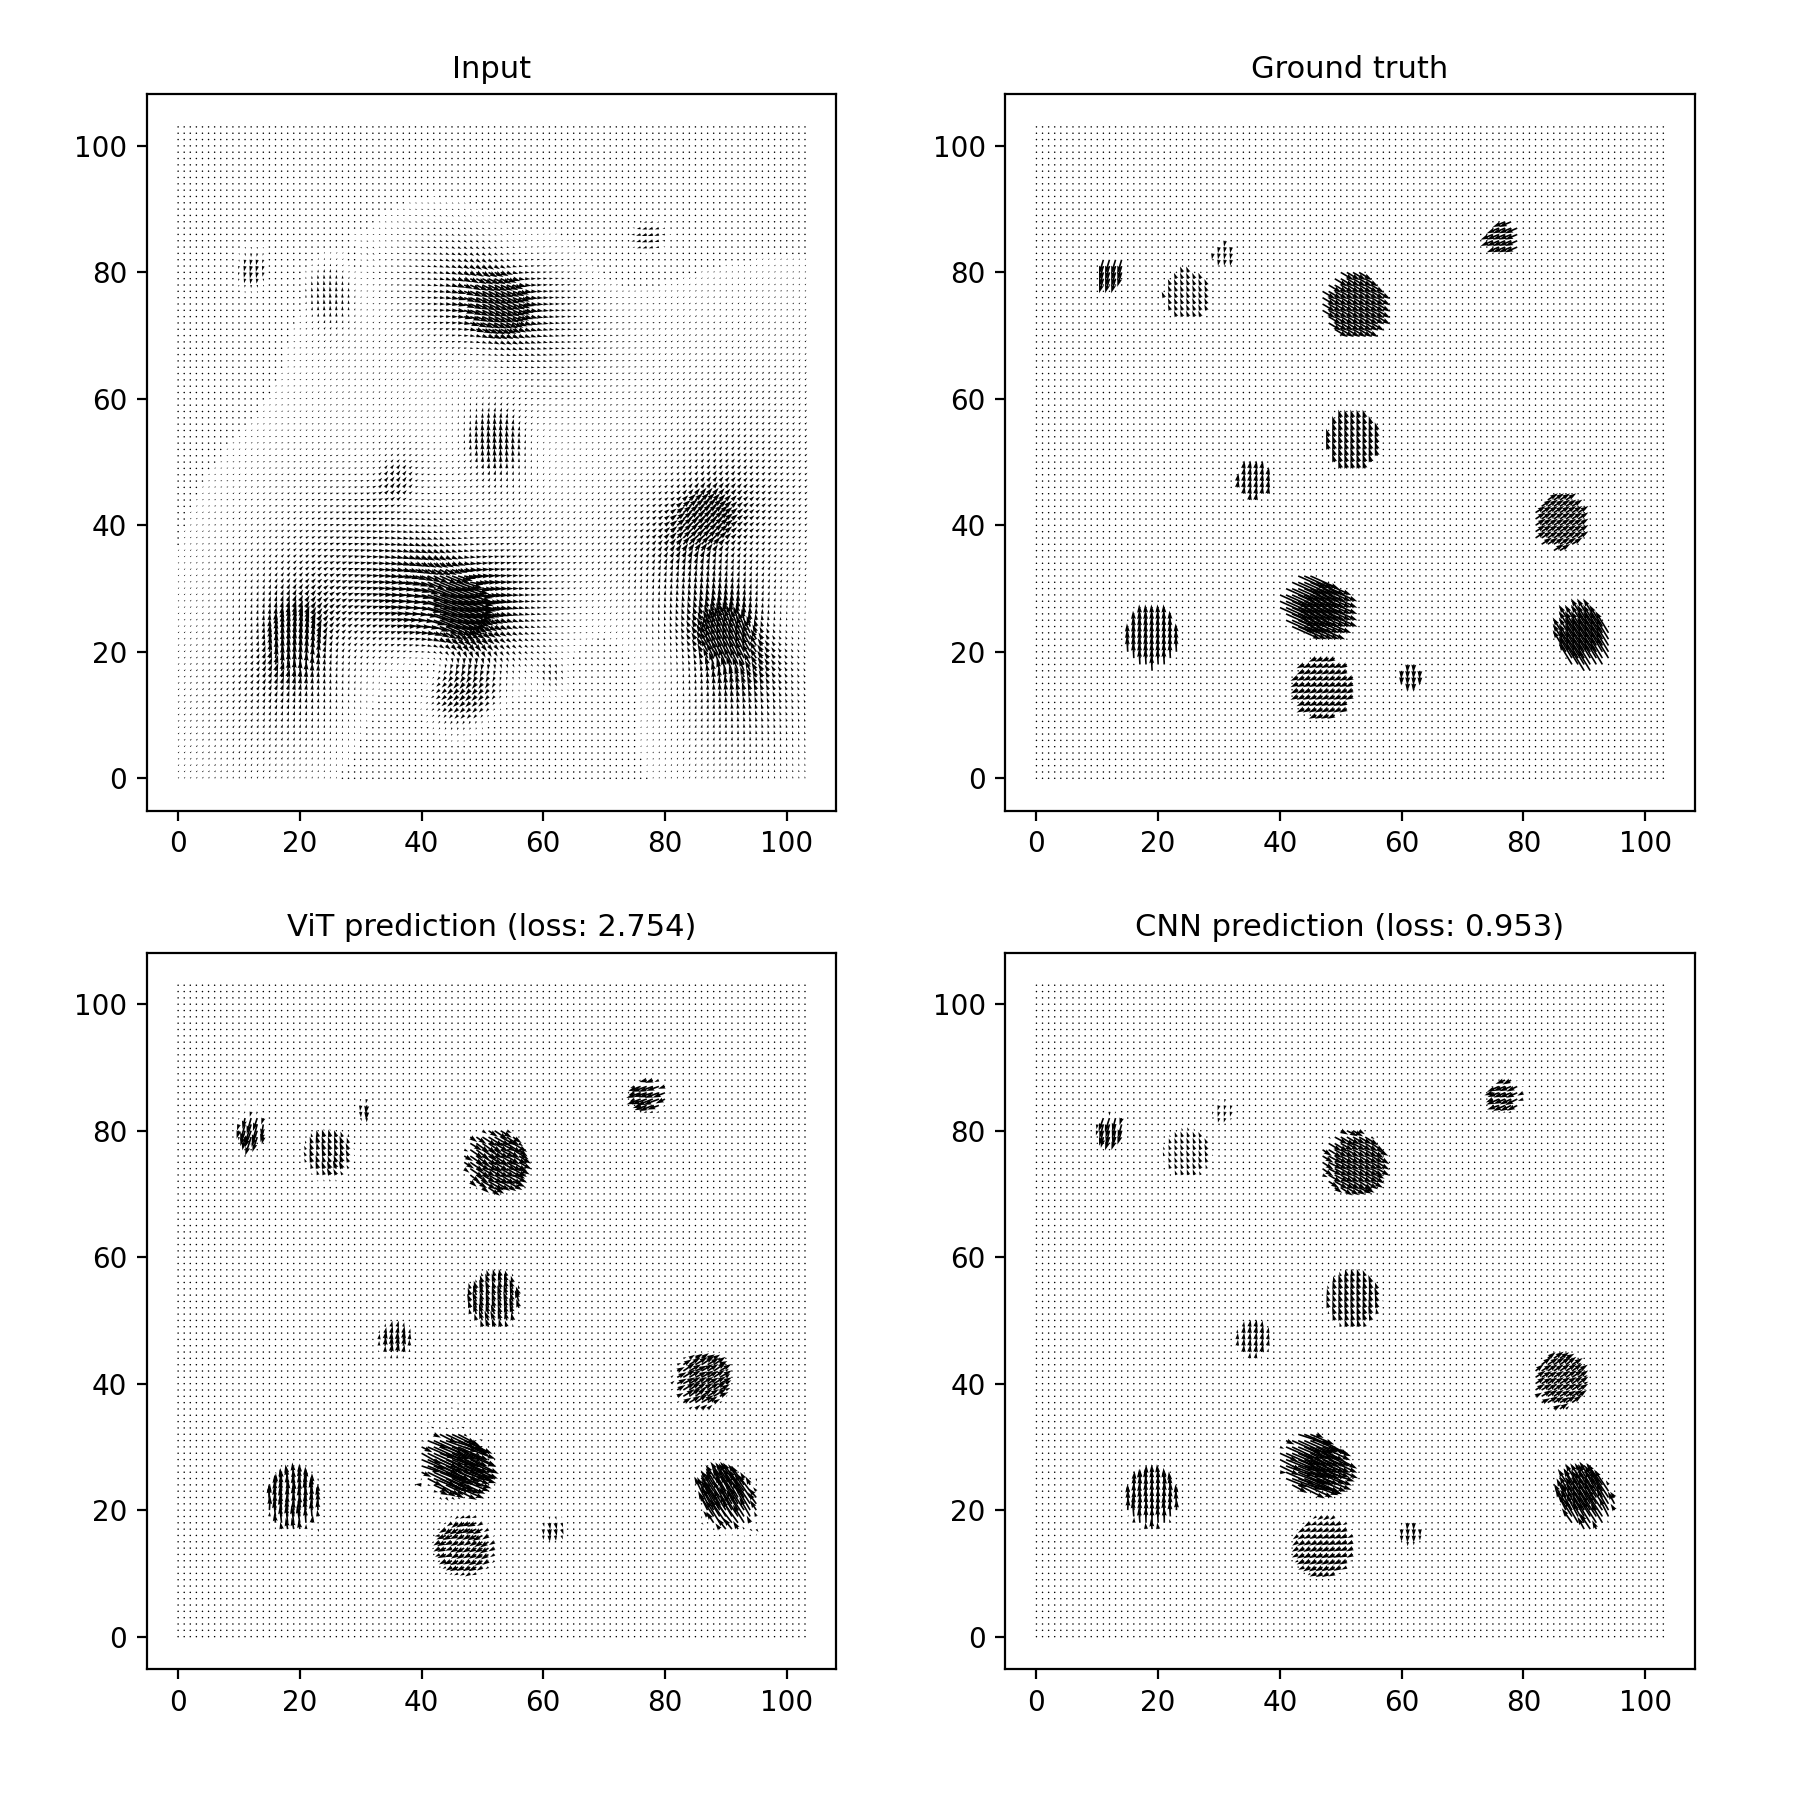

Text(0.5, 1.0, 'CNN prediction (loss: 0.953)')

In [11]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(2,2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(dspl[0,:,:,0], dspl[0,:,:,1], scale=1)
axs[0, 0].set_title('Input', {'fontsize': 11})

axs[0, 1].quiver(trac[0,:,:,0], trac[0,:,:,1], scale=10)
axs[0, 1].set_title('Ground truth', {'fontsize': 11})

axs[1, 0].quiver(pred_vit[0,0,:,:].detach().numpy(), pred_vit[0,1,:,:].detach().numpy(), scale=10)
axs[1, 0].set_title(f'ViT prediction (loss: {torch.round(loss_vit[0,0], decimals=3)})', {'fontsize': 11})

axs[1, 1].quiver(pred_cnn[0,:,:,0], pred_cnn[0,:,:,1], scale=10)
axs[1, 1].set_title(f'CNN prediction (loss: {torch.round(loss_cnn[0,0], decimals=3)})', {'fontsize': 11})

## 3. Optimization possibilities

- Transfer learning
- Complexity of decoder (linear layer, FFNN, Convolutions, 'proper' decoder)
- Pretraining on low-resolution samples and finetuning on high resolution
- Multitask learning: Linear combination of different objectives such as
        - MSE
        - Classification: Split dataset in three groups, corrupt each group with Gaussian noise of different magnitude, infer label
        - Deviation of Traction Magnitude at Adhesions (DTMA)
        - Deviation of Traction Magnitude in the Background (DTMB)
        - Signal to Noise Ratio (SNR)
        - Deviation of Traction Direction at Adhesions (DDA)
- Hyperparameter tuning: 
        - Depth of encoder/decoder
        - patch size
        - embedding dimension
        - number of attention heads
        - mlp ratio (number of hidden layers in MLP module)
        - dropout, attention dropout and stochastic path prob
        - weight initialization
        - optimizer
        - learning rate schedule
        - ... 

## 4. Visualization of attention maps

In this part I visualize the attention heat maps for two test samples.

For the first sample, we extract the attention weights of each encoder block by computing one forward pass.

In [12]:
_, attn_scores = vit_weights((X_test[0, :, :, :][np.newaxis, ...]))

In [13]:
len(attn_scores)

12

As the architecture includes 12 encoder blocks, we get a list of 12 attention tensors. We stack these in a matrix.

In [14]:
attn_mat = torch.stack(attn_scores)

In [15]:
attn_mat.shape

torch.Size([12, 1, 8, 169, 169])

+ 12: Number of encoder blocks
+ 1: Batch size
+ 8: Number of attention heads per encoder block
+ 169: Number of non-overlapping patches in which the displacement fields was tokenized. Each token has one attention weigth for itself and every other token, stored in a (169 x 169) matrix.

We now get rid of the singleton (batch) dimension as we only consider one sample. Then we average over all attention heads per encoder block.

In [16]:
attn_mat = attn_mat.squeeze(1)
attn_mat = torch.mean(attn_mat, dim=1)

To account for residual connections, we add an identity matrix to the
attention matrix and re-normalize the weights.

In [17]:
residual_attn = torch.eye(attn_mat.size(1))
aug_attn_mat = attn_mat + residual_attn
aug_attn_mat = aug_attn_mat / aug_attn_mat.sum(dim=-1).unsqueeze(-1)

Recursively multiply the weight matrices.

In [18]:
joint_attentions = torch.zeros(aug_attn_mat.size())
joint_attentions[0] = aug_attn_mat[0].double()
for n in range(1, aug_attn_mat.size(0)):
    joint_attentions[n] = aug_attn_mat[n].double() @ joint_attentions[n-1].double()
    
grid_size = int(np.sqrt(aug_attn_mat.size(-1)))

Plot first test sample and choose a (8 x 8) patch whose attention weights we will assess.

<IPython.core.display.Javascript object>


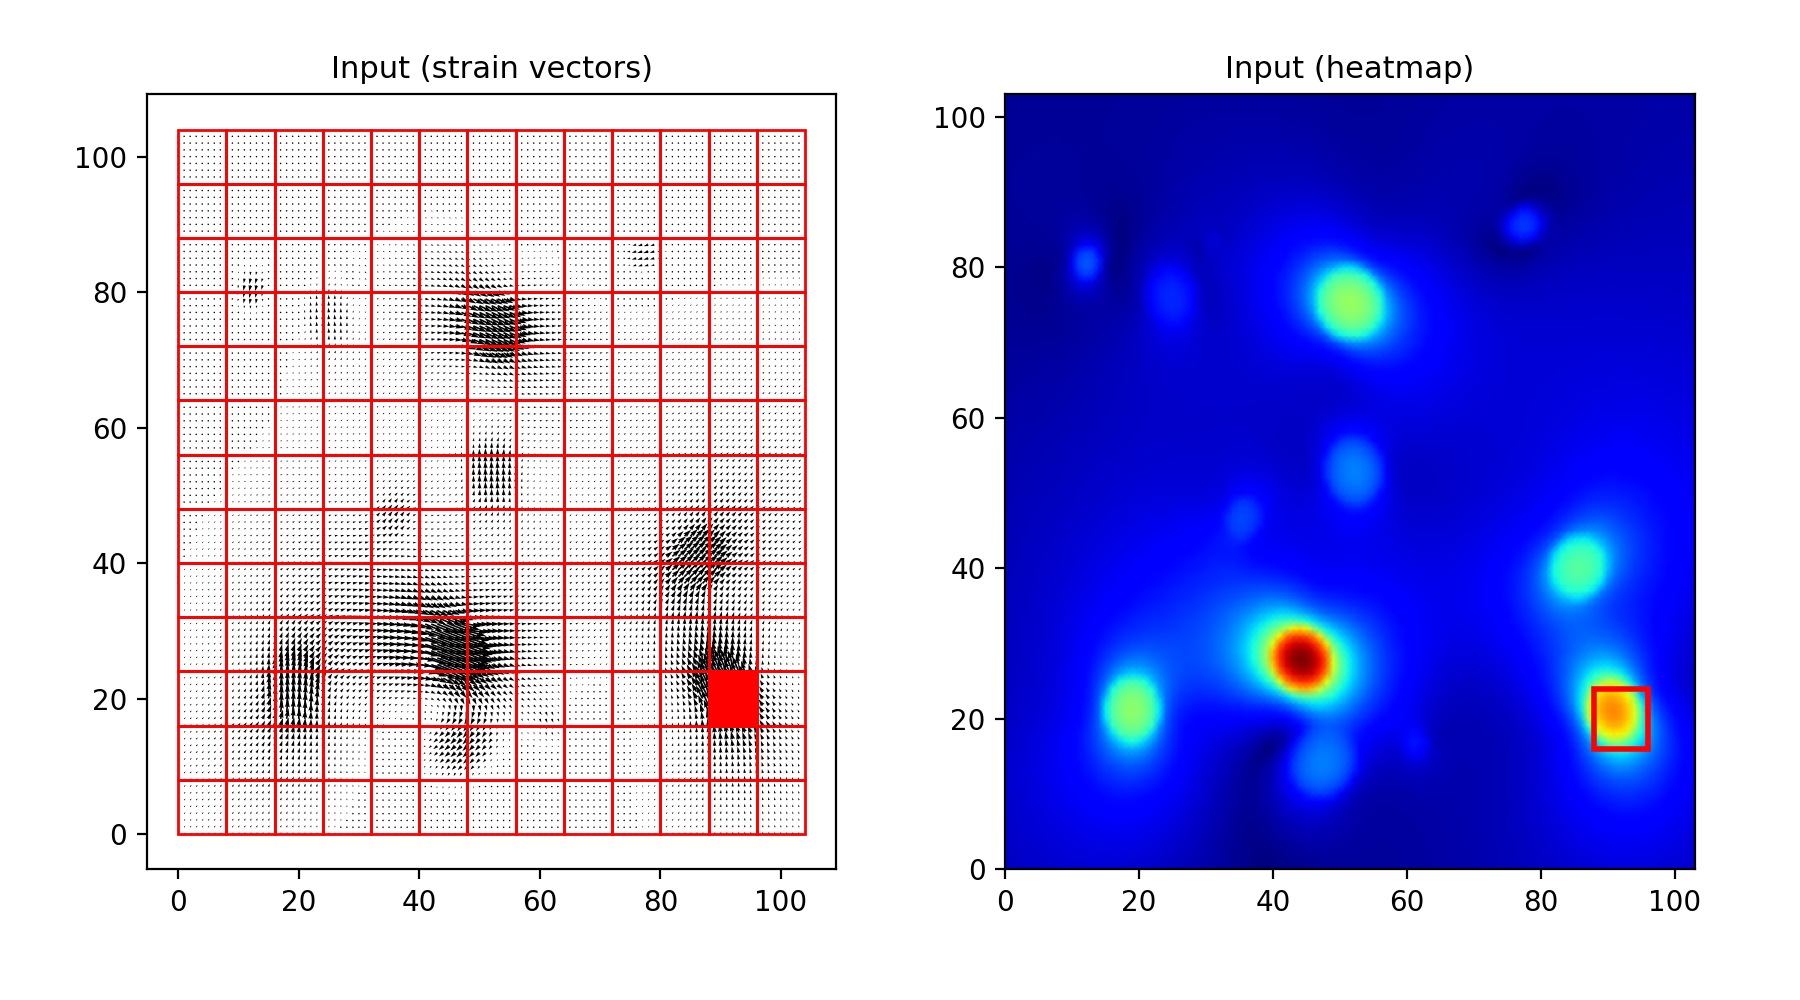

In [19]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(1,2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test[0,0,:,:], X_test[0,1,:,:], scale=1)
axs[0].set_title('Input (strain vectors)', {'fontsize': 11})

C = np.sqrt(X_test[0,0,:,:] **2 + X_test[0,1,:,:] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Input (heatmap)', {'fontsize': 11})


for row in range(0, 13):
    for column in range(0, 13):
        if row == 2 and column == 11:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=True))
        else:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=False))
    
    
axs[1].add_patch(Rectangle(xy=(11*8, 2*8), width=8, height=8, linewidth=2, color='red', fill=False))

Plot attention maps of chosen patch at each encoder block.

<IPython.core.display.Javascript object>


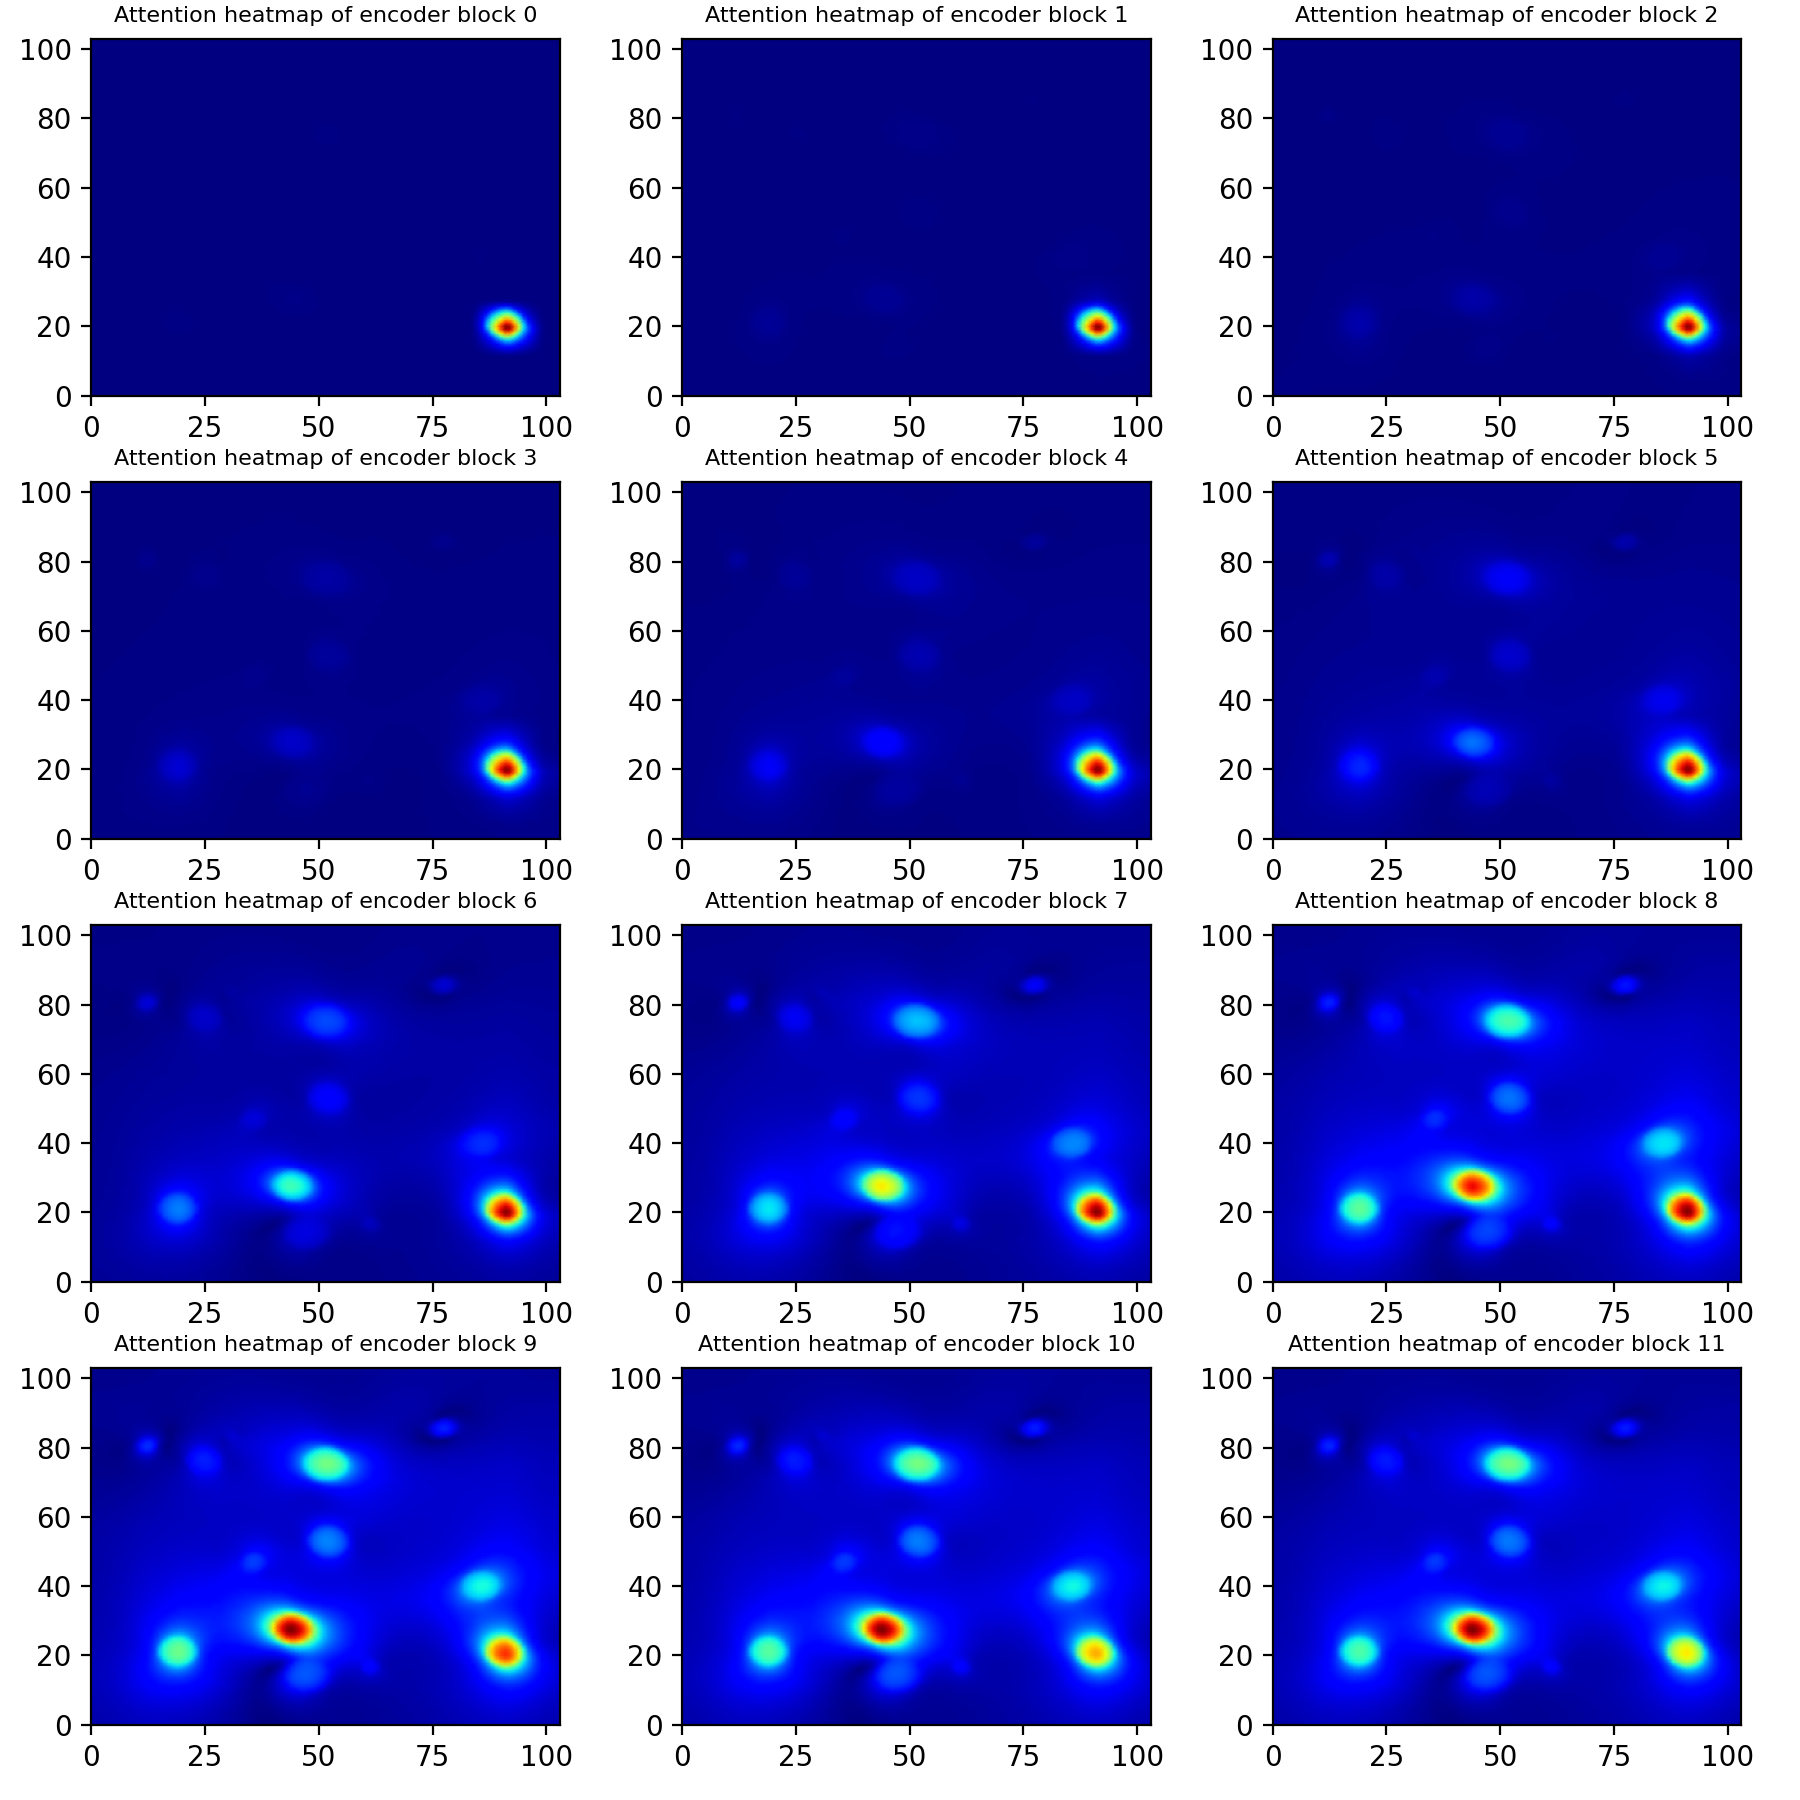

In [20]:
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
fig.tight_layout(pad=1, w_pad=1, h_pad=1)
ind = 0
for i in range(0, 4):
    for j in range(0, 3):
        mask = joint_attentions[ind][37, 0:].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test[0,:,:,:]

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].set_title(f'Attention heatmap of encoder block {ind}', {'fontsize': 8})
        ind += 1

Next, another test sample with a more "cell-like" geometry is analysed. We basicaly perform the same steps as for the first sample.

In [21]:
sys.path.append(f"{os.path.dirname(os.getcwd())}/DL_TFM/scripts/")
from data_preparation import matFiles_to_npArray

In [22]:
X_test = matFiles_to_npArray('../comparables/generic')[1]
Y_test = matFiles_to_npArray('../comparables/generic')[0]
X_test = np.moveaxis(np.array(X_test['dspl'])[np.newaxis, ...], 3, 1)
Y_test = np.moveaxis(np.array(Y_test['trac'])[np.newaxis, ...], 3, 1)

In [23]:
pred, attn_scores = vit_weights(torch.tensor(X_test).double())

In [24]:
attn_mat = torch.stack(attn_scores)
attn_mat = attn_mat.squeeze(1)

# Average the attention weights across all heads.
attn_mat = torch.mean(attn_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_attn = torch.eye(attn_mat.size(1))
aug_attn_mat = attn_mat + residual_attn
aug_attn_mat = aug_attn_mat / aug_attn_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_attn_mat.size())
joint_attentions[0] = aug_attn_mat[0].double()
for n in range(1, aug_attn_mat.size(0)):
    joint_attentions[n] = aug_attn_mat[n].double() @ joint_attentions[n-1].double()

grid_size = int(np.sqrt(aug_attn_mat.size(-1)))

<IPython.core.display.Javascript object>


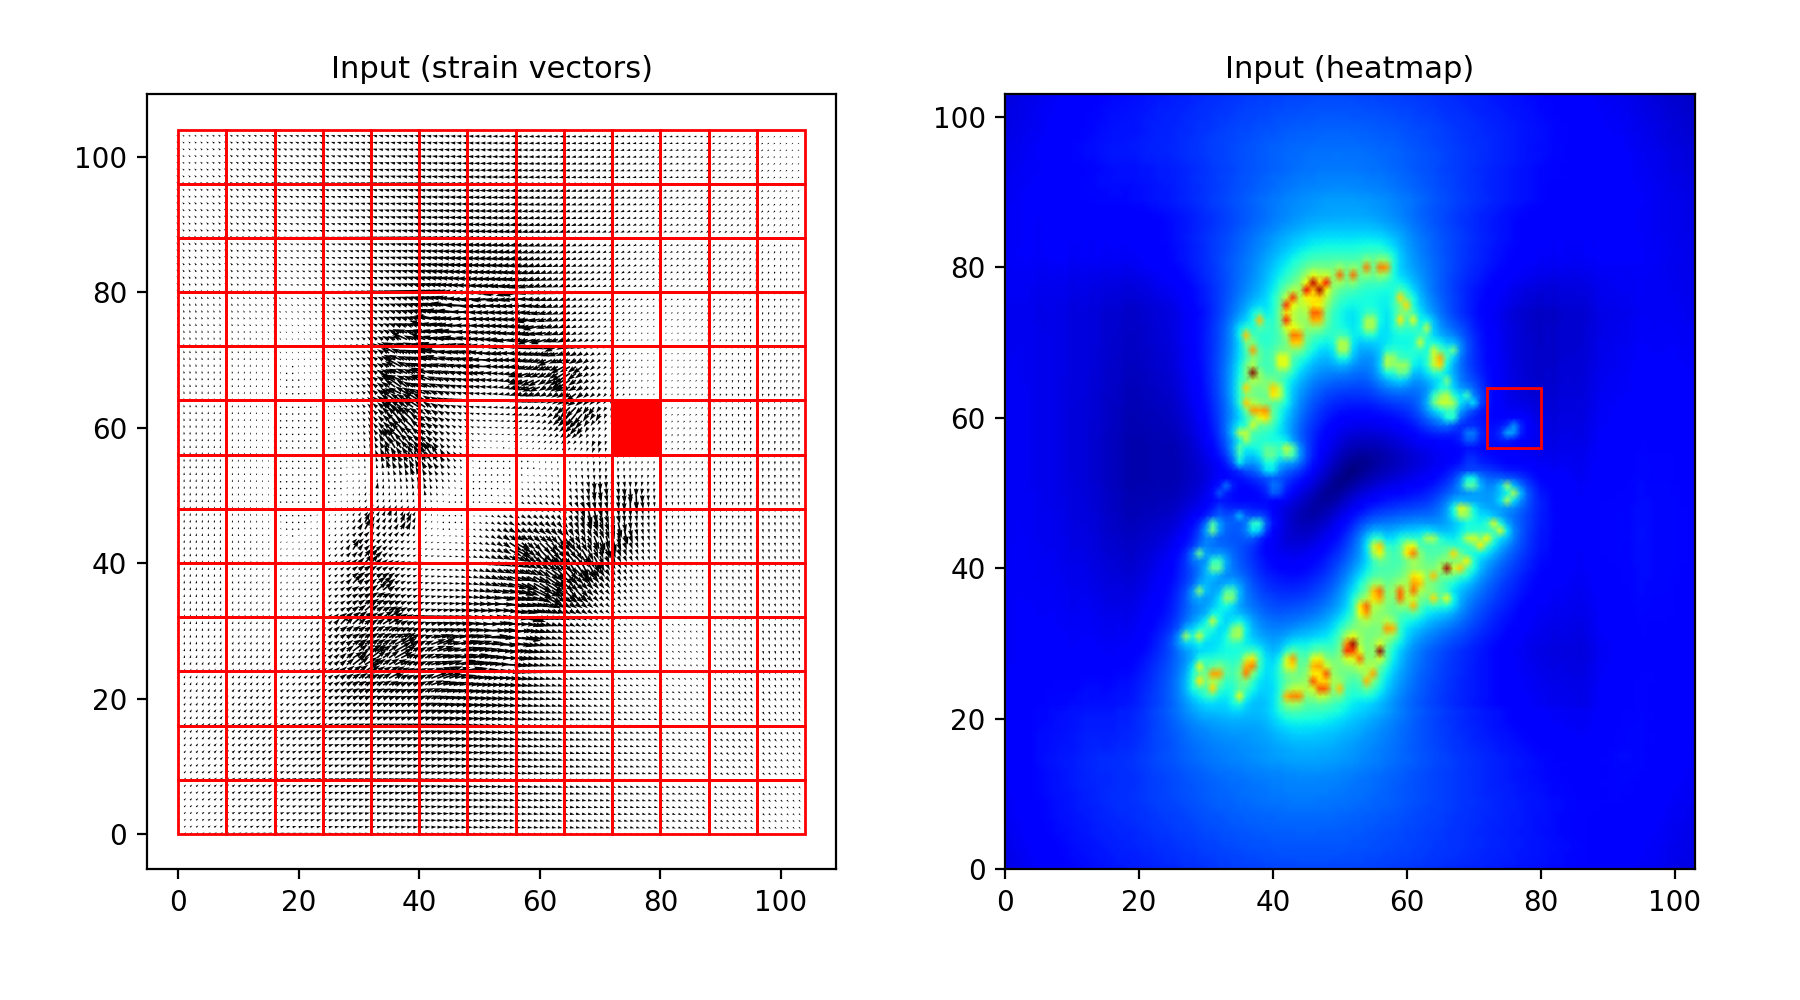

In [25]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(1,2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test[0,0,:,:], X_test[0,1,:,:], scale=20)
axs[0].set_title('Input (strain vectors)', {'fontsize': 11})

C = np.sqrt(X_test[0,0,:,:] **2 + X_test[0,1,:,:] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Input (heatmap)', {'fontsize': 11})


for row in range(0, 13):
    for column in range(0, 13):
        if row == 7 and column == 9:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=True))
        else:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=False))
    
    
axs[1].add_patch(Rectangle(xy=(9*8, 7*8), width=8, height=8, linewidth=1, color='red', fill=False))

<IPython.core.display.Javascript object>


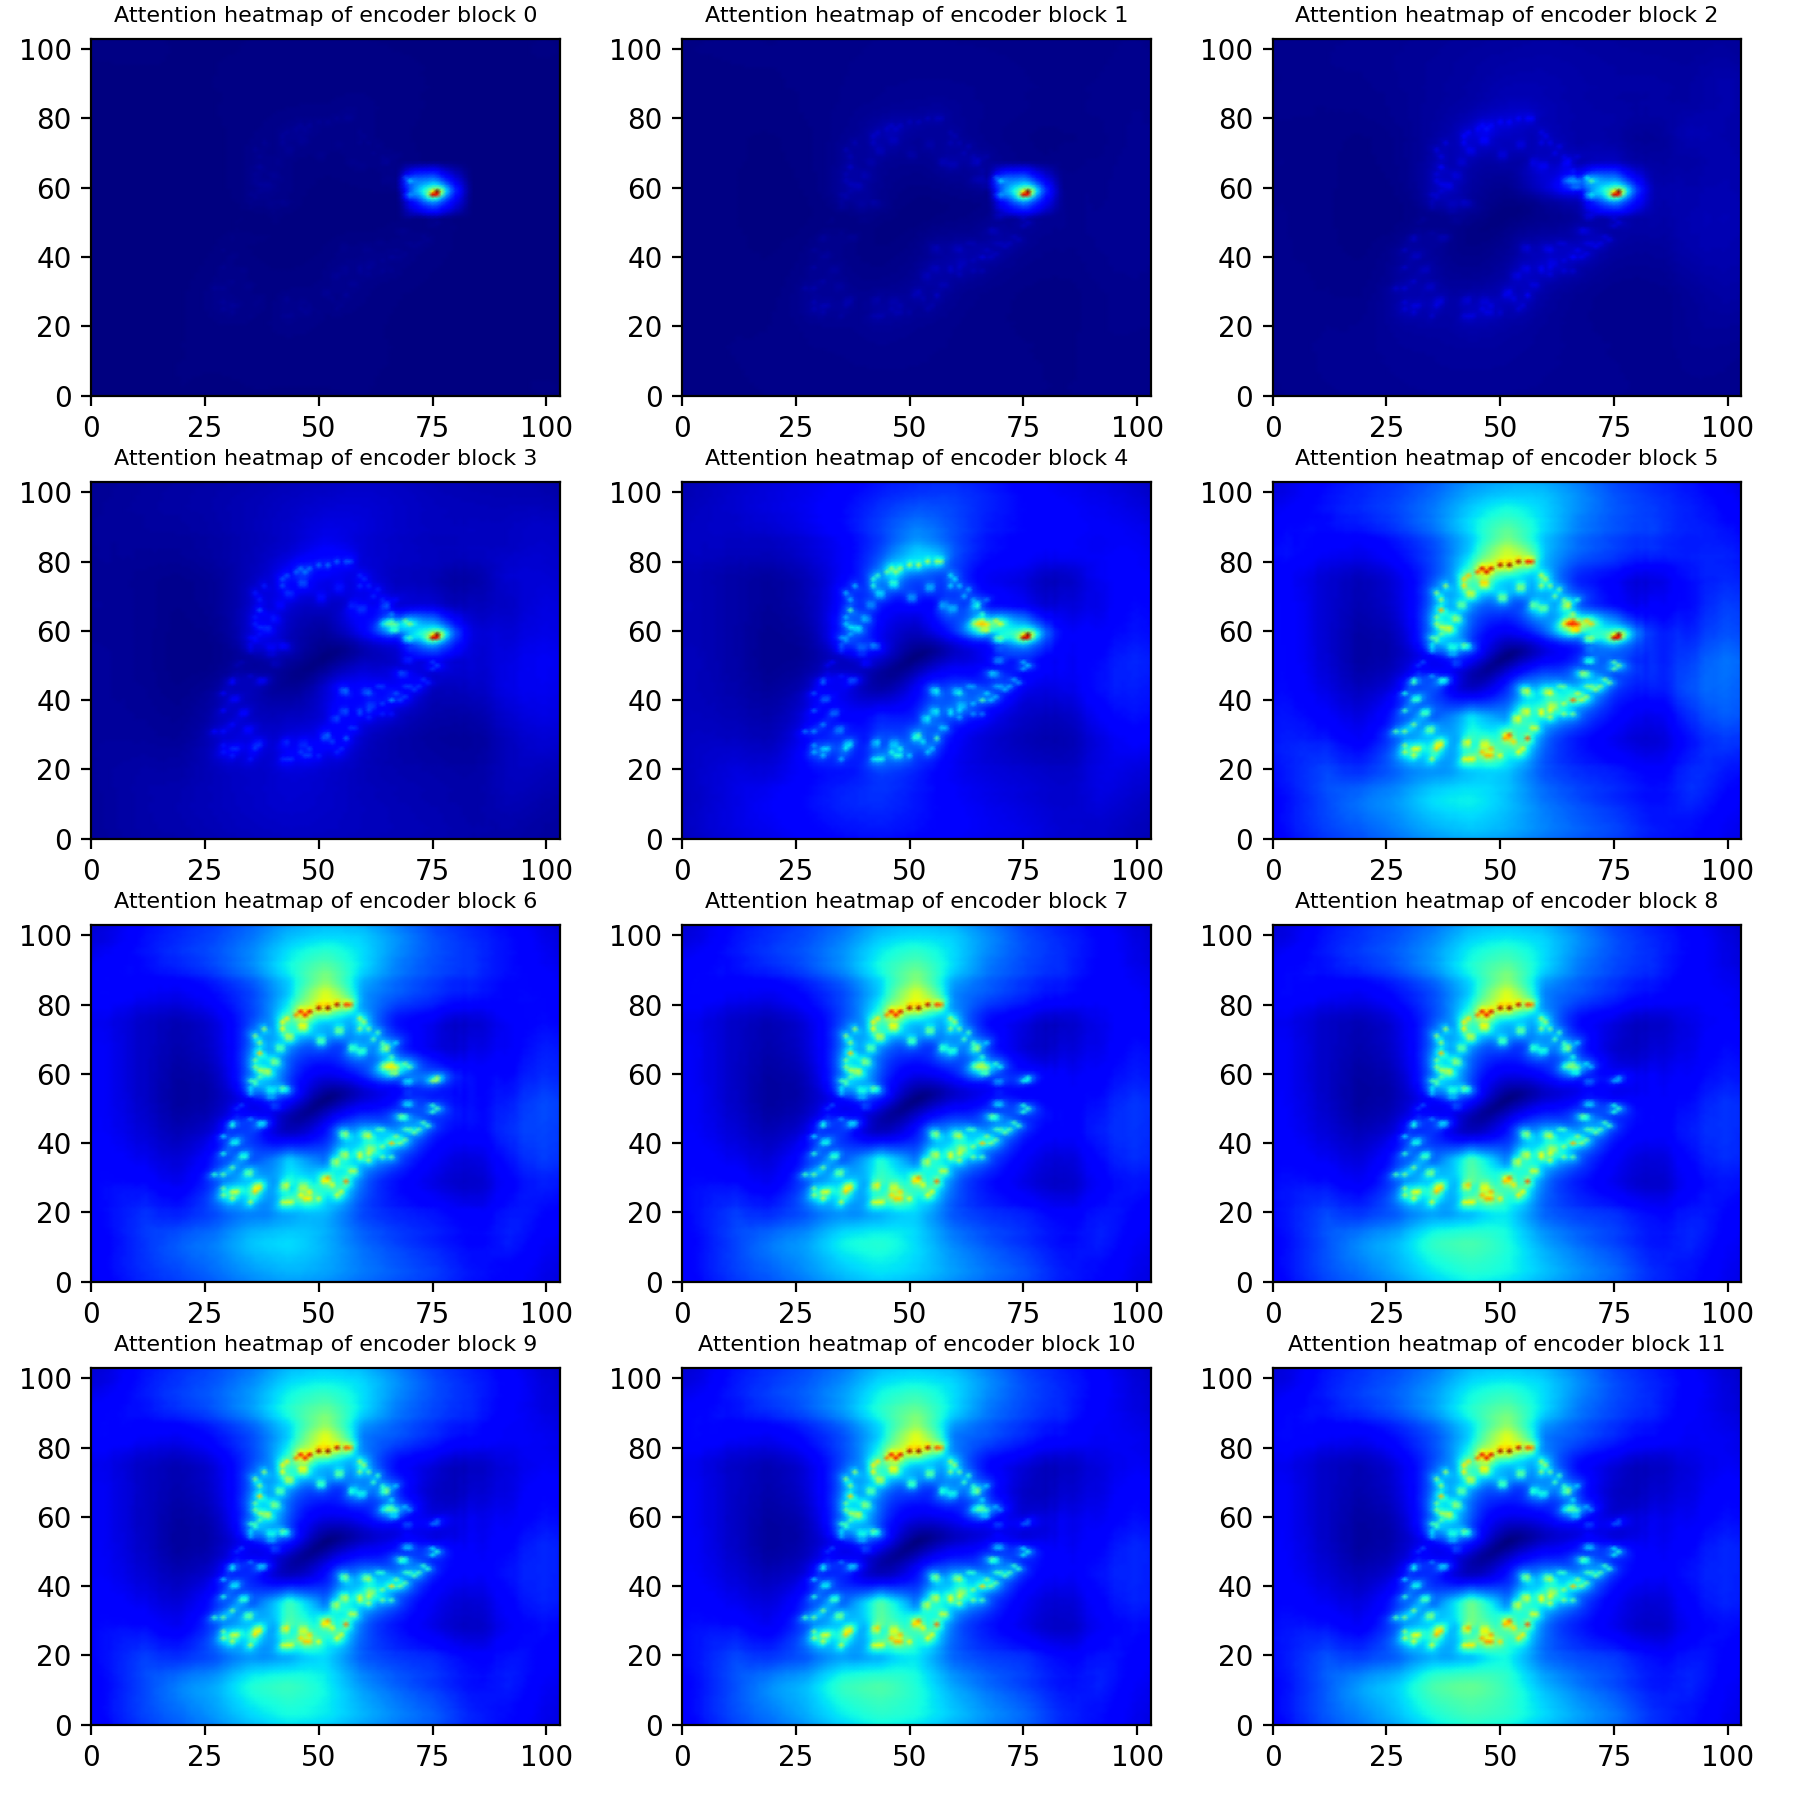

In [26]:
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
fig.tight_layout(pad=1, w_pad=1, h_pad=1)
ind = 0
for i in range(0, 4):
    for j in range(0, 3):
        mask = joint_attentions[ind][100, 0:].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test[0,:,:,:]

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].set_title(f'Attention heatmap of encoder block {ind}', {'fontsize': 8})
        ind += 1

We can conclude that the receptive field changes drastically among the first 6-8 encoder blocks, while the latter blocks basically do not affect the model's attention distribution anymore.